In [ ]:
"""
The dataset consists of aerial imagery of farm land obtained by satellites and annotated with pixel-wise semantic segmentation in 2 classes. The total volume of the dataset is 5 images. The classes are:
Farm land: #3C1098
Unlabeled: #9B9B9B
Use patchify....
Image 1: 530 x 914 -->  512 x 768 --> 6
Image 2: 587 x 914-->  512 x 768 --> 6
Image 3: 547 x 914-->  512 x 768 --> 6
Image 4: 587 x 914 -->  512 x 768 --> 6
Image 5: 547 x 914-->  512 x 768 --> 6
Image 6: 587 x 914 -->  512 x 768 --> 6
Image 7: 547 x 914-->  512 x 768 --> 6
Image 8: 587 x 914-->  256 x 768 --> 3
Image 9: 547 x 914-->  512 x 768 --> 6
Image 10: 572 x 914-->  512 x 768 --> 6
Image 11: 511 x 914-->  256 x 768  --> 3
Image 12: 500 x 914-->  256 x 768 --> 3
Image 13: 508 x 914-->  256 x 768 --> 3
Image 14: 519 x 914-->  512 x 768 --> 6
Total 72 patches of size 256x256
"""

In [11]:
import os
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
from keras.metrics import MeanIoU
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#from sklearn.model_selection import train_test_split

In [ ]:
inDir = ''

os.getcwd()
# Print the current working directory
print('Current working directory: {0}'.format(os.getcwd()))
# IMPORTANT: Update to reflect directory on your OS
# Change to working directory
#os.chdir(inDir)
# Print the current working directory
print('Current working directory: {0}'.format(os.getcwd()))

# images and masks directory
root_directory = 'data/lpol5'

Mask values:
Labels are:  [  0 127 255]  and the counts are:  [373021 103081  11974]


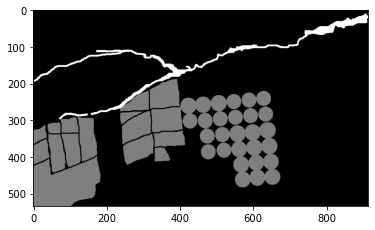

In [13]:
#Quick understanding of the dataset
temp_img = cv2.imread(root_directory+"\\img\\img4.png")
#plt.imshow(temp_img, cmap='gray') #View each channel...
temp_mask = cv2.imread(root_directory+"\\mask\\mask4.png")
plt.imshow(temp_mask, cmap='gray') #View each channel...
labels, count = np.unique(temp_mask[:,:,0], return_counts=True)
print('Mask values:')
print("Labels are: ", labels, " and the counts are: ", count)

In [14]:
#Read images from repsective 'images' subdirectory
#As all images are of ddifferent size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then 
#divide all images into patches of 256x256x3. 

# images and masks directory
#root_directory = 'Semantic segmentation dataset/Tile 1'

# set scaler and patches size
scaler = MinMaxScaler()
patch_size = 256

image_dataset = []
image_size = []
mask_size = []
for path, subdirs, files in os.walk(root_directory):
    #print(path)
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'img':   #Find all 'images' directories
        images = os.listdir(path)  #List of all image names in this subdirectory
        for i, image_name in enumerate(images):  
            if image_name.endswith(".png"):   #Only read jpg images...
                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                SIZE_X = image.shape[1] #Nearest size divisible by our patch size
                SIZE_Y = image.shape[0] #Nearest size divisible by our patch size
                image_shape = [SIZE_X,SIZE_Y]
                image_size.append(image_shape)
            
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)             
    
                #Extract patches from each image
                #print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                        image_dataset.append(single_patch_img)

#Now do the same as above for masks
#For this specific dataset we could have added masks to the above code as masks have extension png
mask_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'mask':   #Find all 'images' directories
        masks = os.listdir(path)  #List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)

                # resize orginal mask
                original_mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(original_mask, cv2.COLOR_BGR2RGB)
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, image_size[i][0], image_size[i][1]))  #Crop from top left corner
                mask = np.array(mask)

                #mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                #mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = mask.shape[1] #Nearest size divisible by our patch size
                SIZE_Y = mask.shape[0] #Nearest size divisible by our patch size
                mask_s = [SIZE_X,SIZE_Y]
                mask_size.append(mask_s)
                
                # crop images to 256 x 256 patches
                #mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                #mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask) 
    
                #Extract patches from each image
                #print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                        mask_dataset.append(single_patch_mask)
    
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

print('Number of patches images:')
print(len(image_dataset))
print('\n')
print('Number of patches masks:')
print(len(mask_dataset))

Number of patches images:
72


Number of patches masks:
72


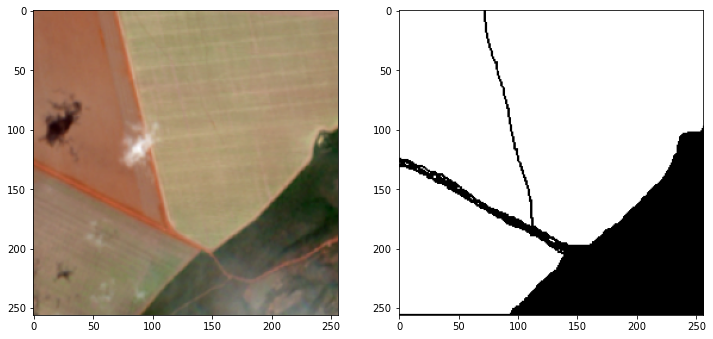

array([  0, 255], dtype=uint8)

In [15]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

un = np.unique(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
un

In [16]:
###########################################################################
"""
RGB to HEX: (Hexadecimel --> base 16)
This number divided by sixteen (integer division; ignoring any remainder) gives 
the first hexadecimal digit (between 0 and F, where the letters A to F represent 
the numbers 10 to 15). The remainder gives the second hexadecimal digit. 
0-9 --> 0-9
10-15 --> A-F
Example: RGB --> R=201, G=, B=
R = 201/16 = 12 with remainder of 9. So hex code for R is C9 (remember C=12)
Calculating RGB from HEX: #3C1098
3C = 3*16 + 12 = 60
10 = 1*16 + 0 = 16
98 = 9*16 + 8 = 152
"""
#Convert HEX to RGB array
# Try the following to understand how python handles hex values...
a=int('3C', 16)  #3C with base 16. Should return 60. 
#print(a)
#Do the same for all RGB channels in each hex code to convert to RGB

# RGB Unlabeled = 250,250,250
FarmLand = '#FFFFFF'.lstrip('#')
FarmLand = np.array(tuple(int(FarmLand[i:i+2], 16) for i in (0, 2, 4)))

# RGB Unlabeled = 127,127,127
Water = '#7F7F7F'.lstrip('#')
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4)))

# RGB Unlabeled = 0,0,0
Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4)))

label = single_patch_mask

# Now replace RGB to integer values to be used as labels.
#Find pixels with combination of RGB for the above defined arrays...
#if matches then replace all values in that pixel with a specific integer
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label==FarmLand,axis=-1)] = 1
    label_seg [np.all(label==Unlabeled,axis=-1)] = 0
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)
 

print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


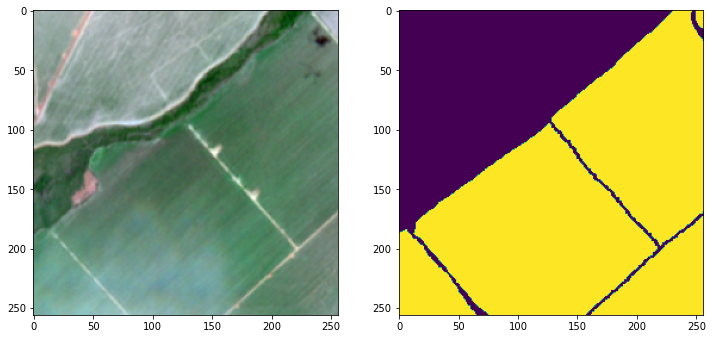

In [17]:
#Another Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

In [18]:
n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

In [19]:
# Parameters for model
from simple_multi_unet_model import multi_unet_model, jacard_coef, iou_coef

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

# Build model
model = get_model()

metrics=['accuracy', jacard_coef]

#model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [20]:
# Parameters for model
from simple_multi_unet_model import jacard_coef, iou_coef

metrics=['accuracy', jacard_coef]
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

history = model.fit(X_train, y_train, 
                    batch_size = 16,
                    verbose=1,
                    epochs=100,
                    validation_data=(X_test, y_test),
                    shuffle=False)

#Minmaxscaler
#With weights...[0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]   in Dice loss
#With focal loss only, after 100 epochs val jacard is: 0.62  (Mean IoU: 0.6)            
#With dice loss only, after 100 epochs val jacard is: 0.74 (Reached 0.7 in 40 epochs)
#With dice + 5 focal, after 100 epochs val jacard is: 0.711 (Mean IoU: 0.611)
##With dice + 1 focal, after 100 epochs val jacard is: 0.75 (Mean IoU: 0.62)
#Using categorical crossentropy as loss: 0.71

##With calculated weights in Dice loss.    
#With dice loss only, after 100 epochs val jacard is: 0.672 (0.52 iou)

##Standardscaler 
#Using categorical crossentropy as loss: 0.677

if not os.path.isdir('models/'):
    
    # if the demo_folder2 directory is 
    # not present then create it.
    os.makedirs('models/')

model.save('models/satellite_standard_unet_100epochs_23Apr2023.hdf5')

Epoch 1/100
4/4 [==============================] - 24s 5s/step - loss: 0.7753 - accuracy: 0.4841 - jacard_coef: 0.3416 - val_loss: 0.5745 - val_accuracy: 0.7978 - val_jacard_coef: 0.4064
Epoch 2/100
4/4 [==============================] - 18s 5s/step - loss: 0.6798 - accuracy: 0.7675 - jacard_coef: 0.4677 - val_loss: 0.6001 - val_accuracy: 0.7998 - val_jacard_coef: 0.3858
Epoch 3/100
4/4 [==============================] - 22s 5s/step - loss: 0.6037 - accuracy: 0.7766 - jacard_coef: 0.4257 - val_loss: 0.5982 - val_accuracy: 0.8000 - val_jacard_coef: 0.3872
Epoch 4/100
4/4 [==============================] - 21s 5s/step - loss: 0.5943 - accuracy: 0.7857 - jacard_coef: 0.4330 - val_loss: 0.5814 - val_accuracy: 0.8000 - val_jacard_coef: 0.4003
Epoch 5/100
4/4 [==============================] - 20s 5s/step - loss: 0.5872 - accuracy: 0.7891 - jacard_coef: 0.4551 - val_loss: 0.5613 - val_accuracy: 0.8000 - val_jacard_coef: 0.4184
Epoch 6/100
4/4 [==============================] - 21s 5s/step - 

In [ ]:
from keras.models import load_model
# load model
#model = load_model("models/satellite_standard_unet_100epochs_23Apr2023.hdf5", custom_objects = {'dice_loss_plus_2focal_loss': total_loss, 'jacard_coef': jacard_coef})
model = load_model("models/satellite_standard_unet_15epochs_23Apr2023.hdf5", compile=False)

C:\Users\cauec\AppData\Local\Temp\ipykernel_14092\2838610918.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y" (-> color=(0.75, 0.75, 0.0, 1)). The keyword argument will take precedence.
  ax1.plot(epochs, loss, 'y', label='Training loss', color='blue')
C:\Users\cauec\AppData\Local\Temp\ipykernel_14092\2838610918.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax1.plot(epochs, val_loss, 'r', label='Validation loss', color='red')
C:\Users\cauec\AppData\Local\Temp\ipykernel_14092\2838610918.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y" (-> color=(0.75, 0.75, 0.0, 1)). The keyword argument will take precedence.
  ax2.plot(epochs, acc, 'y', label='Training IoU', color='blue')
C:\Users\cauec\AppData\Local\Temp\ipykernel_14092\2838610918.py:20: UserWar

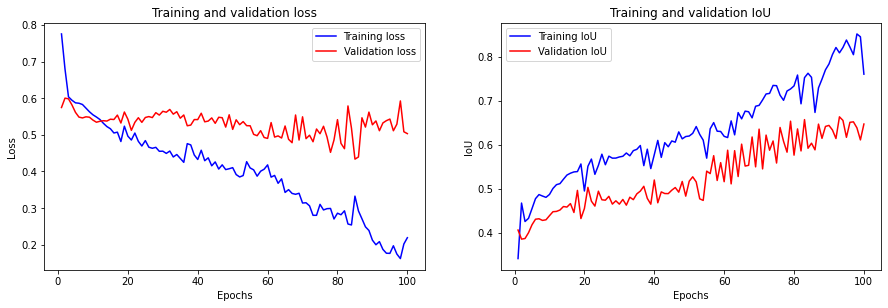

In [48]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

epochs = range(1, len(loss) + 1)

fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(2,2,1)
ax1.plot(epochs, loss, 'y', label='Training loss', color='blue')
ax1.plot(epochs, val_loss, 'r', label='Validation loss', color='red')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2 = fig.add_subplot(2,2,2)
ax2.plot(epochs, acc, 'y', label='Training IoU', color='blue')
ax2.plot(epochs, val_acc, 'r', label='Validation IoU', color='red')
ax2.set_title('Training and validation IoU')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('IoU')
ax2.legend()

plt.savefig('data\\results\\training_loss_iou_v1.png', bbox_inches='tight')

C:\Users\cauec\AppData\Local\Temp\ipykernel_14092\3140198048.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y" (-> color=(0.75, 0.75, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'y', label='Training loss', color='blue')
C:\Users\cauec\AppData\Local\Temp\ipykernel_14092\3140198048.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y" (-> color=(0.75, 0.75, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, acc, 'y', label='Jacard coef', color='cyan')
C:\Users\cauec\AppData\Local\Temp\ipykernel_14092\3140198048.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'r', label='Validation loss', color='red')


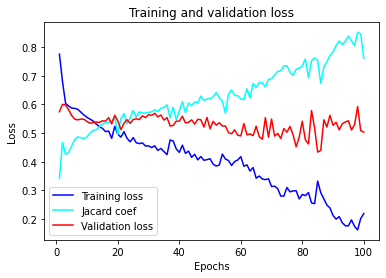

In [52]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'y', label='Training loss', color='blue')
plt.plot(epochs, acc, 'y', label='Jacard coef', color='cyan')
plt.plot(epochs, val_loss, 'r', label='Validation loss', color='red')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [53]:
from keras.metrics import MeanIoU

#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

#Using built in keras function for IoU
#n_classes = len(np.unique(labels))
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - 1s 1s/step
Mean IoU = 0.55833656


In [ ]:
#Predict on a few images
import random
test_img_number = random.randint(0, len(X_test-1))
print(test_img_number)
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
# expand first dimension as U-Net requires (m, h, w, nc) input shape
test_img_input=np.expand_dims(test_img, 0)
# make prediction with model and remove extra dimension
prediction = (model.predict(test_img_input))
# convert softmax probabilities to integer values
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()